In [1]:
import os
import cmdstanpy
from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import describe, gaussian_kde, norm, expon
import multiprocessing
import seaborn as sns
import warnings
import time
import pandas as pd
import math

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 14

In [3]:
from thinning import sample_hawkes_process_thinning_true_vectorised
from utils import exp_kernel_vectorised, constant_background, plot_counting_process
from mle import log_likelihood, optimise_params
from utils import trace_plots, posterior_histograms, posterior_kdes_overlaid, stacked_credible_intervals
from utils import process_csv_data

In [4]:
param_strings = ['mu', 'alpha', 'delta']

In [5]:
data_dir = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\data"

In [6]:
save_dir = r"C:\Users\ethan\OneDrive - University of Bristol\Maths\Year 4\Project\hawkes_project\data_fitting\saved_fits"

In [7]:
np.random.SeedSequence()

SeedSequence(
    entropy=95642684442886275971939149915851030545,
)

In [32]:
seed = 214370650960106687509750059852927702385

In [33]:
rng = np.random.default_rng(seed)

In [34]:
stan_seed = rng.integers(2**32 - 1)
print(stan_seed)

3207695894


In [35]:
stan_seed = 3207695894

# Guinea

In [36]:
data_file_name = "guinea_first_800.csv"

In [37]:
data_file_path = os.path.join(data_dir, data_file_name)

In [38]:
df = pd.read_csv(data_file_path)

In [39]:
df.head()

,date
0,01/01/2014
1,01/01/2014
2,06/01/2014
3,06/01/2014
4,11/01/2014


In [40]:
len(df)

806

In [41]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [42]:
date_numbers_interpolated[-5:]

array([241.28571429, 241.42857143, 241.57142857, 241.71428571,
       241.85714286])

We set max_T to be the beginning of the day after the last event.

In [43]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

242


In [44]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [45]:
mle_params

array([0.34033181, 0.48300684, 0.52470629])

In [46]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -453.21643855851437
        x: [ 3.403e-01  4.830e-01  5.247e-01]
      nit: 13
      jac: [ 3.524e-04  6.708e-04 -7.390e-04]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [47]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [48]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [49]:
save_path = os.path.join(save_dir, 'exponential_priors', 'guinea')

In [ ]:
warmup=250
fit = model_compiled.sample(data=data,
                                seed=stan_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)

23:59:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

In [26]:
fit = cmdstanpy.from_csv(save_path)

In [27]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,436.535000,0.059193,1.301380,433.935000,436.851000,437.991000,483.36,0.238746,1.004190
mu,0.392197,0.004410,0.104044,0.227410,0.387585,0.575392,556.60,0.274922,1.002990
alpha,0.540662,0.004818,0.094142,0.397916,0.535196,0.707641,381.86,0.188612,0.999800
delta,0.604796,0.005851,0.113198,0.432019,0.599686,0.796912,374.32,0.184888,0.999866


In [28]:
print(fit.diagnose())

Processing csv files: .\data_fitting\guinea_exp_priors\exponential_priors-20240425232215_1.csvWarning: non-fatal error reading adaptation data
, .\data_fitting\guinea_exp_priors\exponential_priors-20240425232215_2.csvWarning: non-fatal error reading adaptation data


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



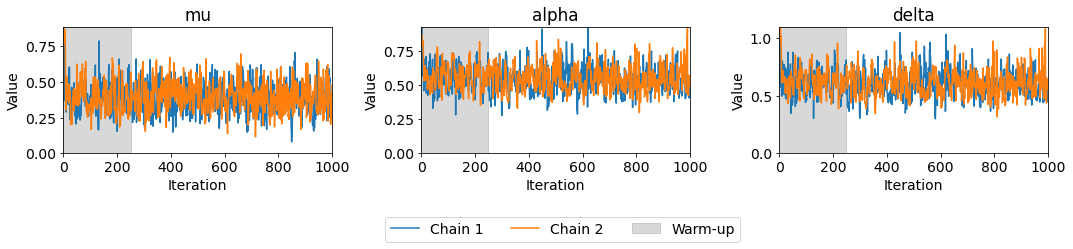

In [31]:
trace_plots([fit], param_strings, warmup=250)

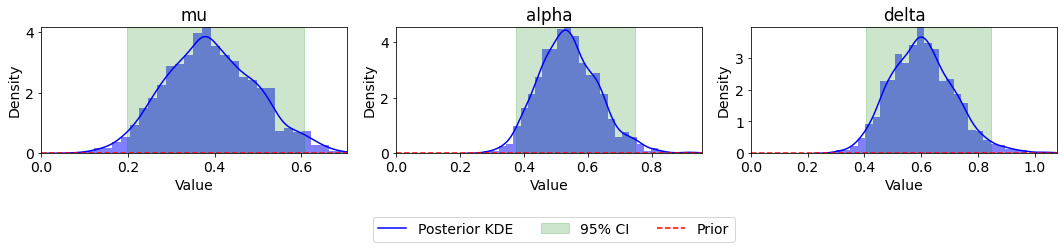

In [32]:
posterior_histograms([fit], param_strings, [lambda x: expon.pdf(x, scale=1/0.01)]*3)

In [33]:
key_parameters_df = fit.draws_pd(['mu', 'alpha', 'delta', 'lp__'])

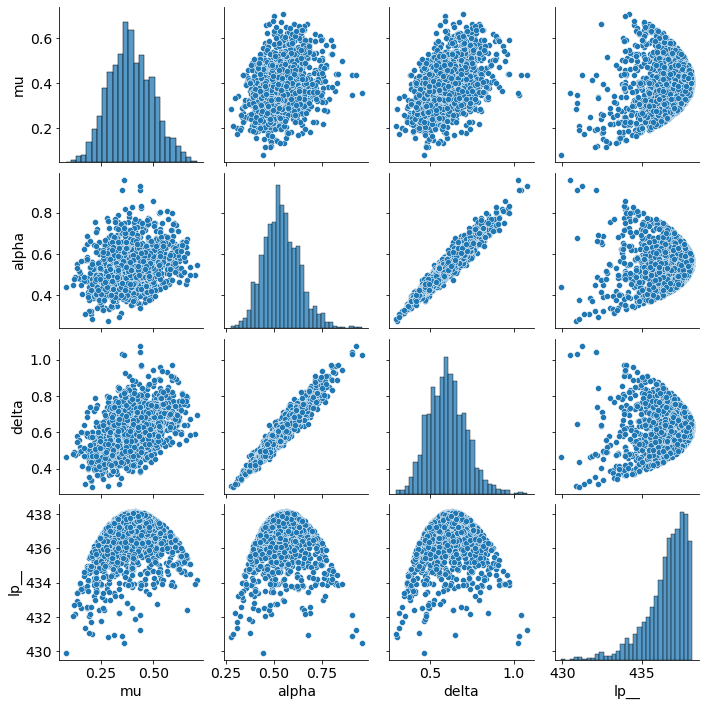

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    sns.pairplot(key_parameters_df)
plt.show()

# Liberia

In [250]:
data_file_name = "liberia_first_800.csv"

In [251]:
data_file_path = os.path.join(data_dir, data_file_name)

In [252]:
df = pd.read_csv(data_file_path)

In [253]:
df.head()

,date
0,23/02/2014
1,24/02/2014
2,28/02/2014
3,01/03/2014
4,03/03/2014


In [254]:
len(df)

805

In [255]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [260]:
date_numbers_interpolated[-50:]

array([161.  , 161.02, 161.04, 161.06, 161.08, 161.1 , 161.12, 161.14,
       161.16, 161.18, 161.2 , 161.22, 161.24, 161.26, 161.28, 161.3 ,
       161.32, 161.34, 161.36, 161.38, 161.4 , 161.42, 161.44, 161.46,
       161.48, 161.5 , 161.52, 161.54, 161.56, 161.58, 161.6 , 161.62,
       161.64, 161.66, 161.68, 161.7 , 161.72, 161.74, 161.76, 161.78,
       161.8 , 161.82, 161.84, 161.86, 161.88, 161.9 , 161.92, 161.94,
       161.96, 161.98])

In [263]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

162


In [264]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [265]:
mle_params

array([0.11723153, 0.37639008, 0.32013824])

In [266]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1325.0480764799606
        x: [ 1.172e-01  3.764e-01  3.201e-01]
      nit: 16
      jac: [ 6.821e-05  2.501e-04 -2.046e-04]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [201]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [205]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [ ]:
save_path = os.path.join(save_dir, 'exponential_priors', 'liberia')

In [206]:
warmup=250
fit = model_compiled.sample(data=data,
                                seed=stan_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)

16:24:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

KeyboardInterrupt: 

# Sierra Leone

In [267]:
data_file_name = "sierra_leone_first_800.csv"

In [268]:
data_file_path = os.path.join(data_dir, data_file_name)

In [269]:
df = pd.read_csv(data_file_path)

In [270]:
df.head()

,date
0,26/12/2013
1,01/01/2014
2,01/01/2014
3,26/01/2014
4,15/02/2014


In [271]:
len(df)

817

In [272]:
date_numbers_interpolated = process_csv_data(data_file_path)

In [277]:
date_numbers_interpolated[-32:]

array([219.     , 219.03125, 219.0625 , 219.09375, 219.125  , 219.15625,
       219.1875 , 219.21875, 219.25   , 219.28125, 219.3125 , 219.34375,
       219.375  , 219.40625, 219.4375 , 219.46875, 219.5    , 219.53125,
       219.5625 , 219.59375, 219.625  , 219.65625, 219.6875 , 219.71875,
       219.75   , 219.78125, 219.8125 , 219.84375, 219.875  , 219.90625,
       219.9375 , 219.96875])

In [278]:
max_T = math.floor(date_numbers_interpolated[-1]) + 1
print(max_T)

220


In [279]:
data = date_numbers_interpolated, max_T
initial_guess = [0.5, 0.5, 0.5]
mle_params, result = optimise_params(data, initial_guess, 1e-6)

In [280]:
mle_params

array([0.09727291, 0.44794132, 0.42783616])

In [281]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1082.2013667243345
        x: [ 9.727e-02  4.479e-01  4.278e-01]
      nit: 9
      jac: [-1.364e-04 -4.547e-04  5.457e-04]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [201]:
stan_file = os.path.join('.', 'bayesian_clean', 'models', 'exponential_priors.stan')
model_compiled = CmdStanModel(stan_file=stan_file,
                                # If you want multi-thread option, need to recompile
                                cpp_options={'STAN_THREADS': 'TRUE'},
                                # turn off below to avoid recompiling
                                # force_compile=True
                                )

In [205]:
data = {
    "N": len(date_numbers_interpolated),
    "events_list": date_numbers_interpolated,
    "max_T": max_T             
}

In [282]:
save_path = os.path.join(save_dir, 'exponential_priors', 'sierra_leone')

In [206]:
warmup=250
fit = model_compiled.sample(data=data,
                                seed=stan_seed,
                                chains=2,
                                parallel_chains=2,
                                iter_warmup=warmup,
                                iter_sampling=3*warmup,
                                inits="0",
                                save_warmup=True,
                                output_dir=save_path)

16:24:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

KeyboardInterrupt: 